# **Topic Modeling with Quantized LLMs**
*Create easily interpretable topics with BERTopic and LLMs*
<br>

<img src="https://pbs.twimg.com/media/GDA2JQoX0AElWoq?format=jpg&name=large">


---
        
💡 **NOTE**: We will want to use a GPU to run both 7B LLMs as well as BERTopic for this use case. In Google Colab, go to
**Runtime > Change runtime type > Hardware accelerator > GPU > GPU type > T4**.

---

We will start by installing a number of packages that we are going to use throughout this example:

In [1]:
"""
%%capture
# BERTopic + llama-cpp-python
!CMAKE_ARGS="-DLLAMA_CUBLAS=on" FORCE_CMAKE=1 pip install llama-cpp-python
!pip install bertopic datasets

# DataMapPlot
!git clone https://github.com/TutteInstitute/datamapplot.git
!pip install datamapplot/.

# GPU-accelerated HDBSCAN + UMAP
!pip install cudf-cu12 dask-cudf-cu12 --extra-index-url=https://pypi.nvidia.com
!pip install cuml-cu12 --extra-index-url=https://pypi.nvidia.com
!pip install cugraph-cu12 --extra-index-url=https://pypi.nvidia.com
!pip install cupy-cuda12x -f https://pip.cupy.dev/aarch64
"""

'\n%%capture\n# BERTopic + llama-cpp-python\n!CMAKE_ARGS="-DLLAMA_CUBLAS=on" FORCE_CMAKE=1 pip install llama-cpp-python\n!pip install bertopic datasets\n\n# DataMapPlot\n!git clone https://github.com/TutteInstitute/datamapplot.git\n!pip install datamapplot/.\n\n# GPU-accelerated HDBSCAN + UMAP\n!pip install cudf-cu12 dask-cudf-cu12 --extra-index-url=https://pypi.nvidia.com\n!pip install cuml-cu12 --extra-index-url=https://pypi.nvidia.com\n!pip install cugraph-cu12 --extra-index-url=https://pypi.nvidia.com\n!pip install cupy-cuda12x -f https://pip.cupy.dev/aarch64\n'

# 📄 **Data**

We are going to apply topic modeling on a number of ArXiv abstracts. They are a great source for topic modeling since they contain a wide variety of topics and are generally well-written.

In [2]:
from datasets import load_dataset

# ArXiv ML Documents
docs = load_dataset("CShorten/ML-ArXiv-Papers")["train"]["abstract"]

In [13]:
docs

['  The problem of statistical learning is to construct a predictor of a random\nvariable $Y$ as a function of a related random variable $X$ on the basis of an\ni.i.d. training sample from the joint distribution of $(X,Y)$. Allowable\npredictors are drawn from some specified class, and the goal is to approach\nasymptotically the performance (expected loss) of the best predictor in the\nclass. We consider the setting in which one has perfect observation of the\n$X$-part of the sample, while the $Y$-part has to be communicated at some\nfinite bit rate. The encoding of the $Y$-values is allowed to depend on the\n$X$-values. Under suitable regularity conditions on the admissible predictors,\nthe underlying family of probability distributions and the loss function, we\ngive an information-theoretic characterization of achievable predictor\nperformance in terms of conditional distortion-rate functions. The ideas are\nillustrated on the example of nonparametric regression in Gaussian noise.\n

# 🦙 **Quantized LLM**

To use a quantized LLMs, we make use of the `GGUF` format together with `llama-cpp-python`. When you access any of [TheBloke's quantized models](https://huggingface.co/TheBloke), you can click on files and find specific quantized formats. We are going with a 4-bit quantized model:

In [3]:
#!wget https://huggingface.co/TheBloke/OpenHermes-2.5-Mistral-7B-GGUF/resolve/main/openhermes-2.5-mistral-7b.Q4_K_M.gguf
# !wget https://huggingface.co/TheBloke/dolphin-2.7-mixtral-8x7b-GGUF/resolve/main/dolphin-2.7-mixtral-8x7b.Q3_K_M.gguf

Next, we load the model using `llama-cpp-python`:

In [4]:
from llama_cpp import Llama

# Use llama.cpp to load in a Quantized LLM
model_path="/home/maitre/Documents/Development/text-generation-webui/models/openhermes-2.5-mistral-7b.Q4_K_M.gguf"
llm = Llama(model_path=model_path, n_gpu_layers=-1, n_ctx=4096, stop=["Q:", "\n"])

ggml_init_cublas: GGML_CUDA_FORCE_MMQ:   no
ggml_init_cublas: CUDA_USE_TENSOR_CORES: yes
ggml_init_cublas: found 1 CUDA devices:
  Device 0: NVIDIA GeForce RTX 3090, compute capability 8.6, VMM: yes
llama_model_loader: loaded meta data with 20 key-value pairs and 291 tensors from /home/maitre/Documents/Development/text-generation-webui/models/openhermes-2.5-mistral-7b.Q4_K_M.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.name str              = teknium_openhermes-2.5-mistral-7b
llama_model_loader: - kv   2:                       llama.context_length u32              = 32768
llama_model_loader: - kv   3:                     llama.embedding_length u32              = 4096
llama_model_loader: - kv   4:                          llama.block_count 

.......................................................................................
llama_new_context_with_model: n_ctx      = 4096
llama_new_context_with_model: freq_base  = 10000.0
llama_new_context_with_model: freq_scale = 1
llama_kv_cache_init:      CUDA0 KV buffer size =   512.00 MiB
llama_new_context_with_model: KV self size  =  512.00 MiB, K (f16):  256.00 MiB, V (f16):  256.00 MiB
llama_new_context_with_model:  CUDA_Host input buffer size   =    17.04 MiB
llama_new_context_with_model:      CUDA0 compute buffer size =   296.02 MiB
llama_new_context_with_model:  CUDA_Host compute buffer size =     8.00 MiB
llama_new_context_with_model: graph splits (measure): 3
AVX = 1 | AVX_VNNI = 0 | AVX2 = 1 | AVX512 = 0 | AVX512_VBMI = 0 | AVX512_VNNI = 0 | FMA = 1 | NEON = 0 | ARM_FMA = 0 | F16C = 1 | FP16_VA = 0 | WASM_SIMD = 0 | BLAS = 1 | SSE3 = 1 | SSSE3 = 1 | VSX = 0 | MATMUL_INT8 = 0 | 
Model metadata: {'tokenizer.ggml.padding_token_id': '0', 'tokenizer.ggml.eos_token_id': '32000',

We pass the LLM to BERTopic with a custom prompt. Let's add `KeyBERTInspired` representations to compare the LLM representations with:

In [5]:
from bertopic.representation import KeyBERTInspired, LlamaCPP

prompt = """ Q:
I have a topic that contains the following documents:
[DOCUMENTS]

The topic is described by the following keywords: '[KEYWORDS]'.

Based on the above information, can you give a short label of the topic of at most 5 words?
A:
"""

representation_model = {
    "KeyBERT": KeyBERTInspired(),
    "LLM": LlamaCPP(llm, prompt=prompt),
}

# 🗨️ **BERTopic**

By pre-calculating the embeddings for each document, we can speed-up additional exploration steps and use the embeddings to quickly iterate over BERTopic's hyperparameters if needed.

🔥 **TIP**: You can find a great overview of good embeddings for clustering on the [MTEB Leaderboard](https://huggingface.co/spaces/mteb/leaderboard).

In [6]:
from sentence_transformers import SentenceTransformer
from cuml.manifold import UMAP
from cuml.cluster import HDBSCAN
# from umap import UMAP
# from hdbscan import HDBSCAN

# Pre-calculate embeddings
embedding_model = SentenceTransformer("BAAI/bge-small-en")
embeddings = embedding_model.encode(docs, show_progress_bar=True)

# Pre-reduce embeddings for visualization purposes
reduced_embeddings = UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine', random_state=42).fit_transform(embeddings)

Batches:   0%|          | 0/3675 [00:00<?, ?it/s]

In [7]:
# Define sub-models
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)
hdbscan_model = HDBSCAN(min_cluster_size=400, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

# 🔥 **Training**

Now that we have our models prepared, we can start training our topic model! We supply BERTopic with the sub-models of interest, run `.fit_transform`, and see what kind of topics we get.

In [8]:
from bertopic import BERTopic

topic_model = BERTopic(

  # Sub-models
  embedding_model=embedding_model,
  umap_model=umap_model,
  hdbscan_model=hdbscan_model,
  representation_model=representation_model,

  # Hyperparameters
  top_n_words=10,
  verbose=True
)

# Train model
topics, probs = topic_model.fit_transform(docs, embeddings)

2024-03-10 16:27:03,492 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-03-10 16:27:05,599 - BERTopic - Dimensionality - Completed ✓
2024-03-10 16:27:05,601 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-03-10 16:27:11,421 - BERTopic - Cluster - Completed ✓
2024-03-10 16:27:11,436 - BERTopic - Representation - Extracting topics from clusters using representation models.
  0%|          | 0/33 [00:00<?, ?it/s]
llama_print_timings:        load time =     190.46 ms
llama_print_timings:      sample time =       2.48 ms /     9 runs   (    0.28 ms per token,  3621.73 tokens per second)
llama_print_timings: prompt eval time =     411.46 ms /  1140 tokens (    0.36 ms per token,  2770.59 tokens per second)
llama_print_timings:        eval time =      79.33 ms /     8 runs   (    9.92 ms per token,   100.85 tokens per second)
llama_print_timings:       total time =     513.66 ms /  1148 tokens
  3%|▎         | 1/33 [00:00<00:16,  1.92it/s]L

Now that we are done training our model, let's see what topics were generated:

In [9]:
# Show topics
topic_model.get_topic_info()

,Topic,Count,Name,Representation,KeyBERT,LLM,Representative_Docs
0,-1,60273,-1_the_of_and_to,"[the, of, and, to, in, we, is, for, that, on]","[datasets, models, model, algorithms, learning...",[Machine Learning Representation and Algorithm...,[ Gaussian Mixture Models are one of the most...
1,0,7177,0_policy_learning_the_reinforcement,"[policy, learning, the, reinforcement, to, in,...","[learning, reinforcement, dynamics, robot, mod...",[Reinforcement Learning Policies and Imitation...,[ Applying reinforcement learning (RL) method...
2,1,6448,1_the_and_of_to,"[the, and, of, to, in, for, data, is, we, with]","[convolutional, mri, imaging, trained, predict...","[Deep Learning in Medical Image Analysis, , , ...",[ Deep learning methods are successfully used...
3,2,6040,2_language_the_and_of,"[language, the, and, of, to, in, we, text, on,...","[embeddings, nlp, language, representations, s...","[Language Modeling with Transfer Learning, , ,...",[ Pretrained contextualized text representati...
4,3,3496,3_the_to_and_of,"[the, to, and, of, we, generative, image, in, ...","[gans, adversarial, gan, generative, models, m...","[Generative Adversarial Networks, , , , , , , ...",[ Generative adversarial networks (GANs) have...
5,4,2812,4_speech_audio_the_speaker,"[speech, audio, the, speaker, to, of, and, in,...","[speech, voice, language, models, neural, mode...",[Speech Separation and Enhancement\n\nQ:\nWhic...,[ Deep learning models are becoming predomina...
6,5,2809,5_privacy_federated_fl_data,"[privacy, federated, fl, data, the, learning, ...","[federated, distributed, datasets, model, mode...",[Federated Learning Privacy\nB:\nFederated Lea...,[Federated learning allows many devices to col...
7,6,2584,6_adversarial_attacks_attack_robustness,"[adversarial, attacks, attack, robustness, the...","[adversarial, dnns, attacks, models, model, at...",[Adversarial Attacks and Robustness in Deep Ne...,[ Recent studies on the adversarial vulnerabi...
8,7,1933,7_the_of_and_to,"[the, of, and, to, in, for, is, equations, neu...","[modeling, dynamics, pdes, models, pde, simula...",[Partial Differential Equations and Deep Learn...,[ In typical machine learning tasks and appli...
9,8,1815,8_graph_node_graphs_the,"[graph, node, graphs, the, nodes, gnns, of, an...","[graphs, graph, embeddings, networks, embeddin...","[""Graph Representation Learning"", , , , , , , ...",[ Graph Neural Networks (GNNs) are an effecti...


# 📊 Visualization with DataMapPlot

In [10]:
import PIL
import numpy as np
import requests

# Prepare logo
bertopic_logo_response = requests.get(
    "https://raw.githubusercontent.com/MaartenGr/BERTopic/master/images/logo.png",
    stream=True,
    headers={'User-Agent': 'My User Agent 1.0'}
)
bertopic_logo = np.asarray(PIL.Image.open(bertopic_logo_response.raw))

We can use the labels created by the LLM and assign them to topics that we have created:

(<Figure size 1200x1200 with 1 Axes>,
 <Axes: title={'left': 'Topics labeled with `openhermes-2.5-mistral-7b`'}>)

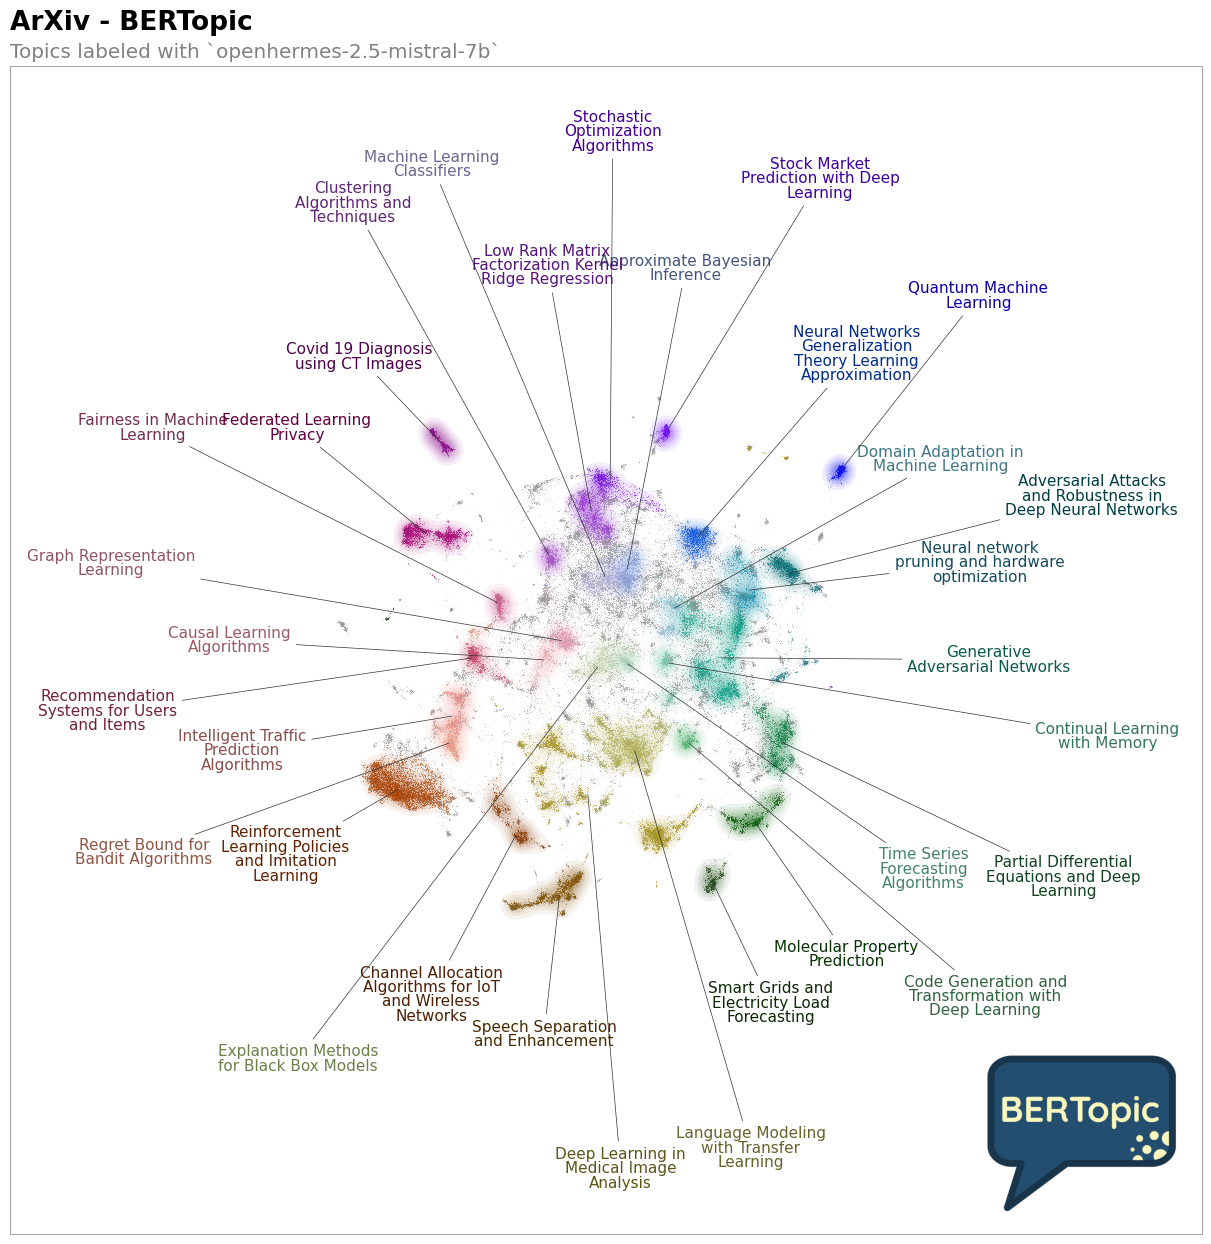

In [11]:
import datamapplot
import re

# Create a label for each document
llm_labels = [re.sub(r'\W+', ' ', label[0][0].split("\n")[0].replace('"', '')) for label in topic_model.get_topics(full=True)["LLM"].values()]
llm_labels = [label if label else "Unlabelled" for label in llm_labels]
all_labels = [llm_labels[topic+topic_model._outliers] if topic != -1 else "Unlabelled" for topic in topics]

# Run the visualization
datamapplot.create_plot(
    reduced_embeddings,
    all_labels,
    label_font_size=11,
    title="ArXiv - BERTopic",
    sub_title="Topics labeled with `openhermes-2.5-mistral-7b`",
    label_wrap_width=20,
    use_medoids=True,
    logo=bertopic_logo,
    logo_width=0.16
)